In [35]:
###########Download necessary libraries###########
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# from causalml.inference.meta import LRSRegressor, XGBTRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor, BaseSRegressor
# from causalml.propensity import ElasticNetPropensityModel
# from causalml.inference.tf import DragonNet
# from causalml.metrics import get_cumgain, plot_gain, *
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import joblib

import warnings
warnings.filterwarnings("ignore")


In [24]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Artur\OneDrive\Documentos\GitHub\Superstore-Marketing-Campaign\superstore_data.csv")

# Display basic information
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [25]:
data.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


#### **Data exploration**

In [26]:
###########Null values handling and analysis###########
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64


In [27]:
#Looking at the characteristics of the missing values
missing_income = data[data['Income'].isnull()]
print("Profile of customers with missing income:")
print(missing_income.describe())
## There are some noteworthy patterns in the data mainly that the
## size of the househol tend to be high, with one kid and one teen at home
## also these missing income does not respond well to the offer 4% only

Profile of customers with missing income:
                 Id   Year_Birth  Income    Kidhome   Teenhome    Recency  \
count     24.000000    24.000000     0.0  24.000000  24.000000  24.000000   
mean    5943.625000  1967.458333     NaN   0.666667   0.583333  58.041667   
std     3028.349268    12.021644     NaN   0.637022   0.583592  29.492046   
min     1295.000000  1943.000000     NaN   0.000000   0.000000   4.000000   
25%     3063.250000  1957.750000     NaN   0.000000   0.000000  35.500000   
50%     5526.500000  1969.500000     NaN   1.000000   1.000000  62.000000   
75%     8597.750000  1974.250000     NaN   1.000000   1.000000  82.250000   
max    10629.000000  1989.000000     NaN   2.000000   2.000000  96.000000   

         MntWines   MntFruits  MntMeatProducts  MntFishProducts  \
count   24.000000   24.000000        24.000000        24.000000   
mean   197.208333   21.333333       162.708333        27.166667   
std    242.479758   38.310705       339.420411        41.281290

In [28]:
## Since we have few data points missing and relatively low variation
## in household size and purchase pattern we decide to input based on median 
## and create a new column to indicate if it's been imputed or not

## since there only 24 missing values we could consider also drop them 

# Binary column to flag original missing values
# data['Income_Imputed'] = data['Income'].isnull().astype(int)

# # Create imputation based on store purchase patterns
# store_income_median = data.groupby('NumStorePurchases')['Income'].transform('median')
# data['Income'] = data['Income'].fillna(store_income_median)

# # Compare original vs imputed value distributions
# print("\nOriginal Income Distribution:")
# print(data[data['Income_Imputed'] == 0]['Income'].describe())
# print("\nImputed Income Distribution:")
# print(data[data['Income_Imputed'] == 1]['Income'].describe())


In [31]:
###########Identify and separate type of columns###########
# Change Dt_Customer to datetime type for a better visualization 
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

# Identify numeric columns
numeric_col_names = data.select_dtypes(include=['number']).columns.tolist()

# Separate numeric columns into binary vs non-binary
binary_cols = []
numeric_cols = []
for col in numeric_col_names:
    unique_vals = data[col].dropna().unique()
    if len(unique_vals) == 2:
        binary_cols.append(col)
    else:
        numeric_cols.append(col)

# Identify datetime columns
datetime_cols = data.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Identify categorical columns (everything else)
all_non_numeric = [col for col in data.columns if col not in numeric_col_names]
categorical_cols = [col for col in all_non_numeric if col not in datetime_cols]

# Print the results
print("Binary columns:", binary_cols)
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("Datetime columns:", datetime_cols)

Binary columns: ['Response', 'Complain']
Numeric columns: ['Id', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
Categorical columns: ['Education', 'Marital_Status']
Datetime columns: ['Dt_Customer']


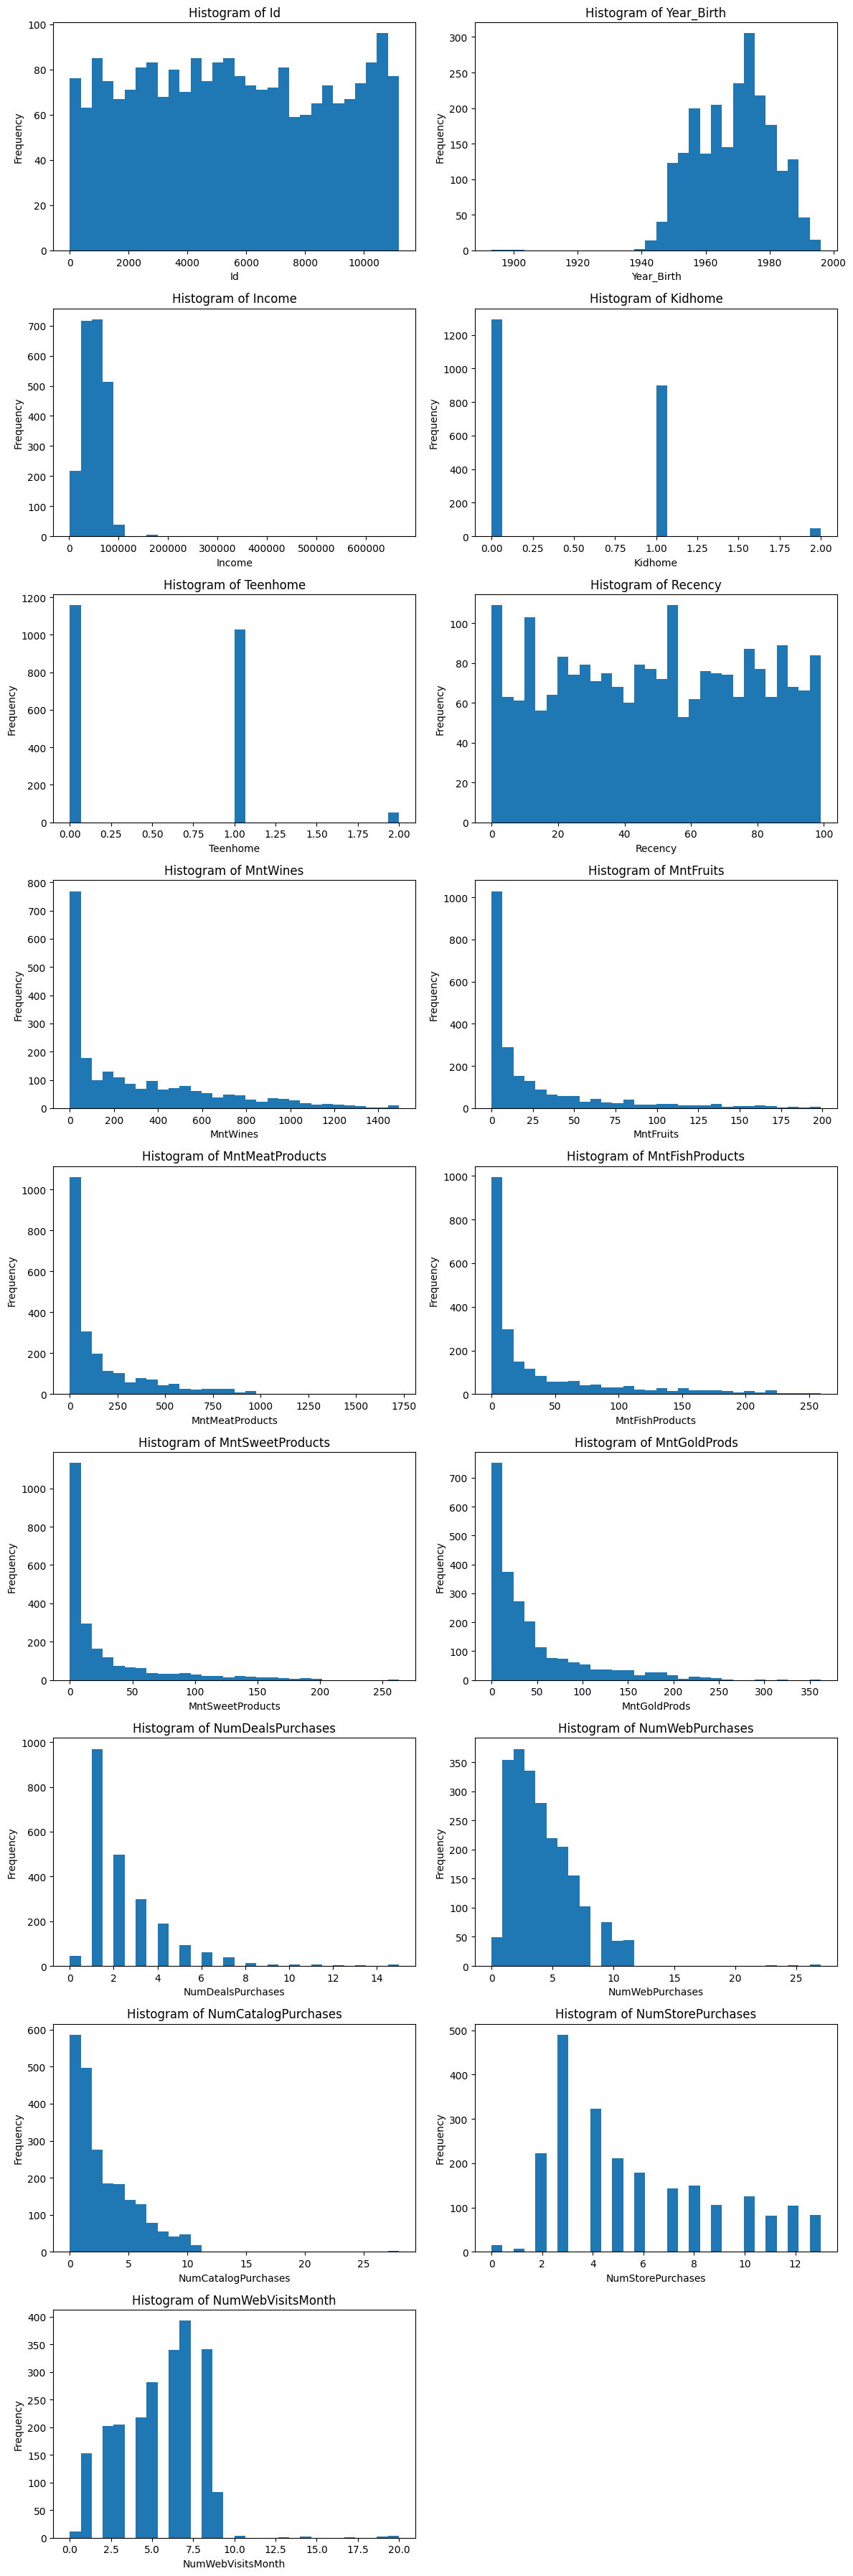

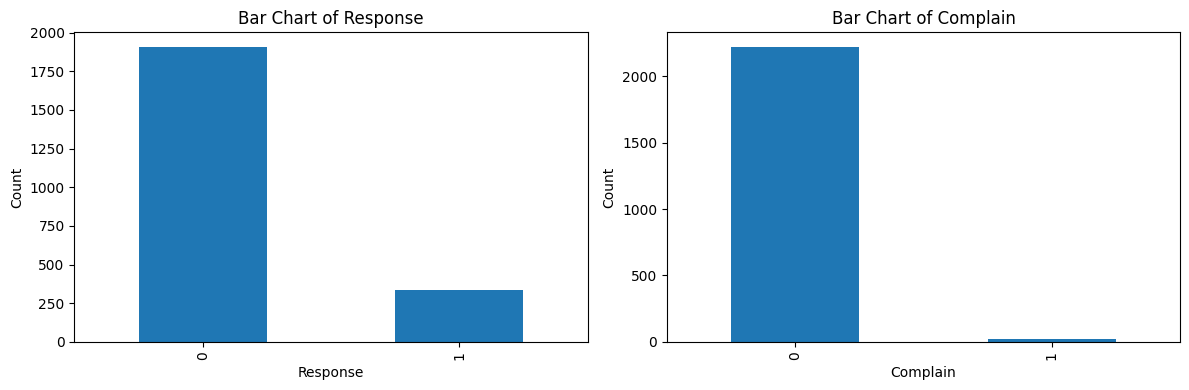

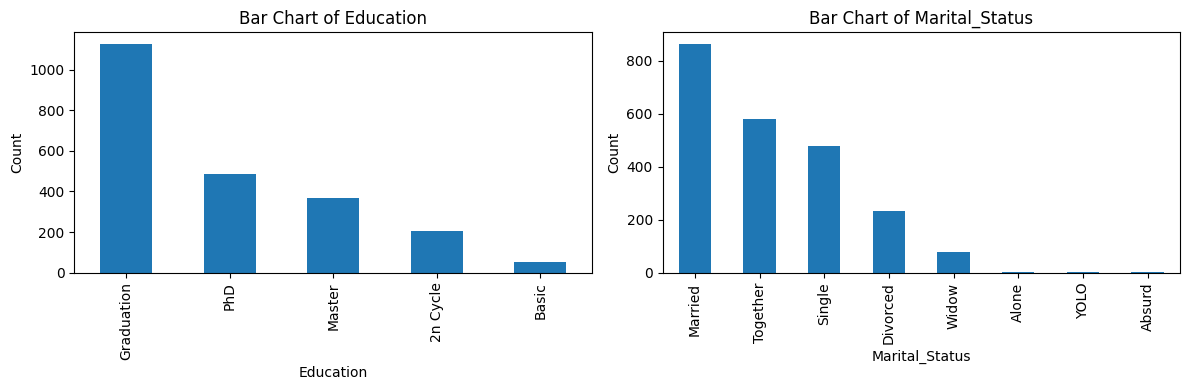

In [36]:
# Plot histograms for numeric columns
num_plots = len(numeric_cols)          # total number of numeric columns
rows = math.ceil(num_plots / 2)        # how many rows of subplots we need
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))  # create a grid of subplots
axes = axes.flatten()                 

for i, col in enumerate(numeric_cols):
    axes[i].hist(data[col].dropna(), bins=30) 
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# If there's an odd number of columns, turn off the unused subplot(s)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Plot bar charts for binary columns
bin_plots = len(binary_cols)
rows = math.ceil(bin_plots / 2)
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))
axes = axes.flatten()

for i, col in enumerate(binary_cols):
    data[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Bar Chart of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# Plot bar charts for categorical columns
cat_plots = len(categorical_cols)
rows = math.ceil(cat_plots / 2)
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    data[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Bar Chart of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

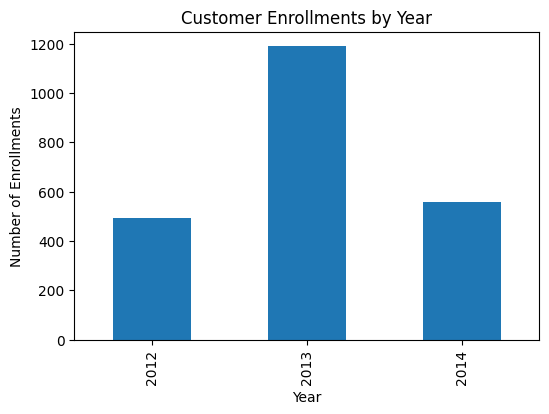

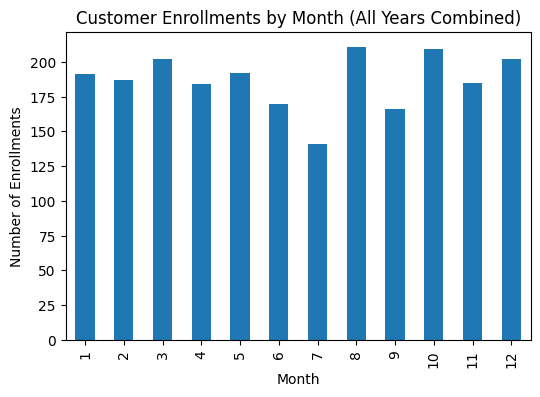

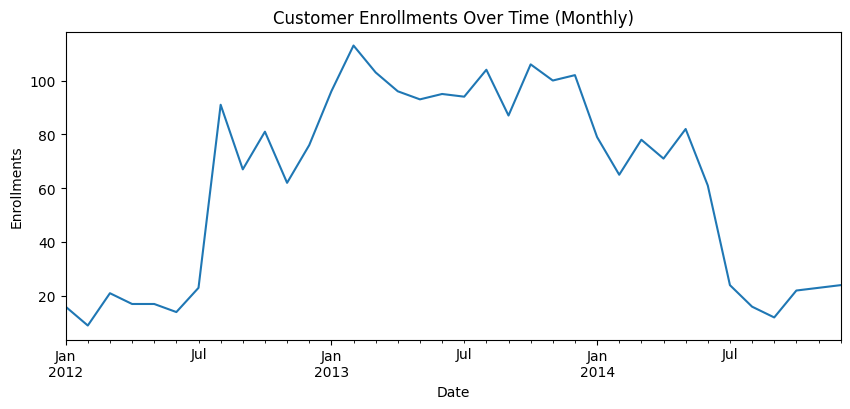

In [ ]:
# Count enrollments by year
enrollments_per_year = data['Dt_Customer'].dt.year.value_counts().sort_index()

plt.figure(figsize=(6,4))
enrollments_per_year.plot(kind='bar')
plt.title('Customer Enrollments by Year')
plt.xlabel('Year')
plt.ylabel('Number of Enrollments')
plt.show()

# Count enrollments by month
enrollments_per_month = data['Dt_Customer'].dt.month.value_counts().sort_index()

plt.figure(figsize=(6,4))
enrollments_per_month.plot(kind='bar')
plt.title('Customer Enrollments by Month (All Years Combined)')
plt.xlabel('Month')
plt.ylabel('Number of Enrollments')
plt.show()


# Resample by month and count how many enrollments occurred each month
data.set_index('Dt_Customer', inplace=True)  # Temporarily make Dt_Customer the index
enrollments_ts = data.resample('M').size()   # Count rows per month

plt.figure(figsize=(10,4))
enrollments_ts.plot()
plt.title('Customer Enrollments Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Enrollments')
plt.show()

data.reset_index(inplace=True)

data.reset_index(inplace=True)


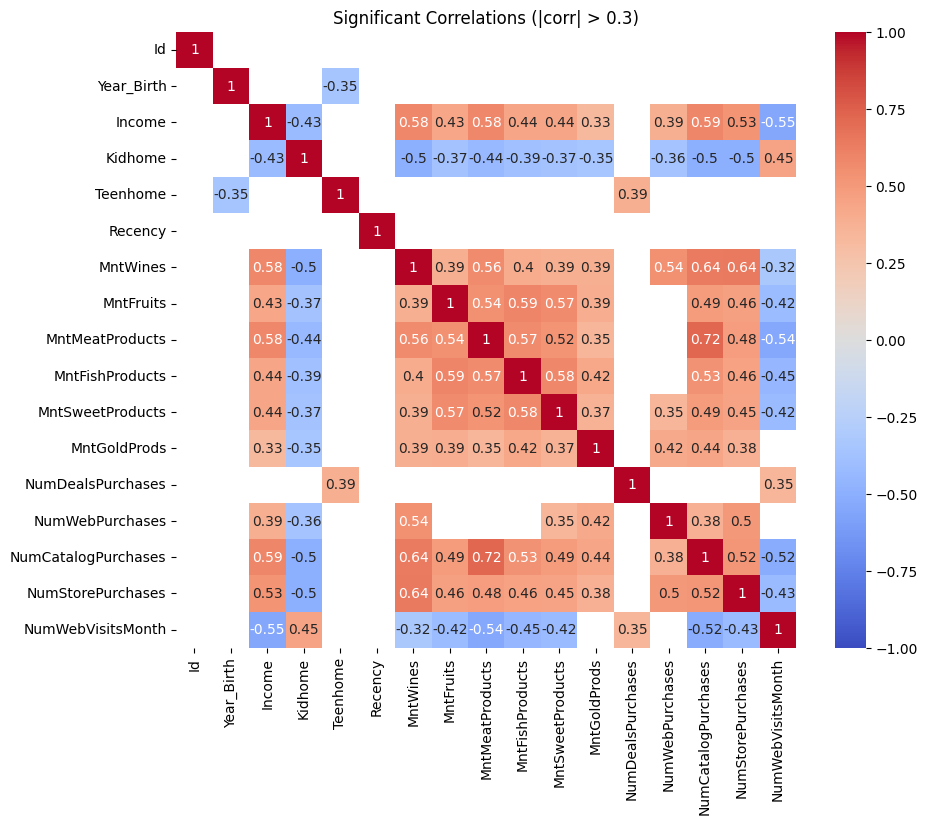

In [42]:
# Correlation heatmap
numeric_data = data[numeric_cols]

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Create a boolean mask where values within [-0.3, 0.3] are True
mask = corr_matrix.abs() < 0.3

# Plot heatmap using the mask
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Significant Correlations (|corr| > 0.3)")
plt.show()

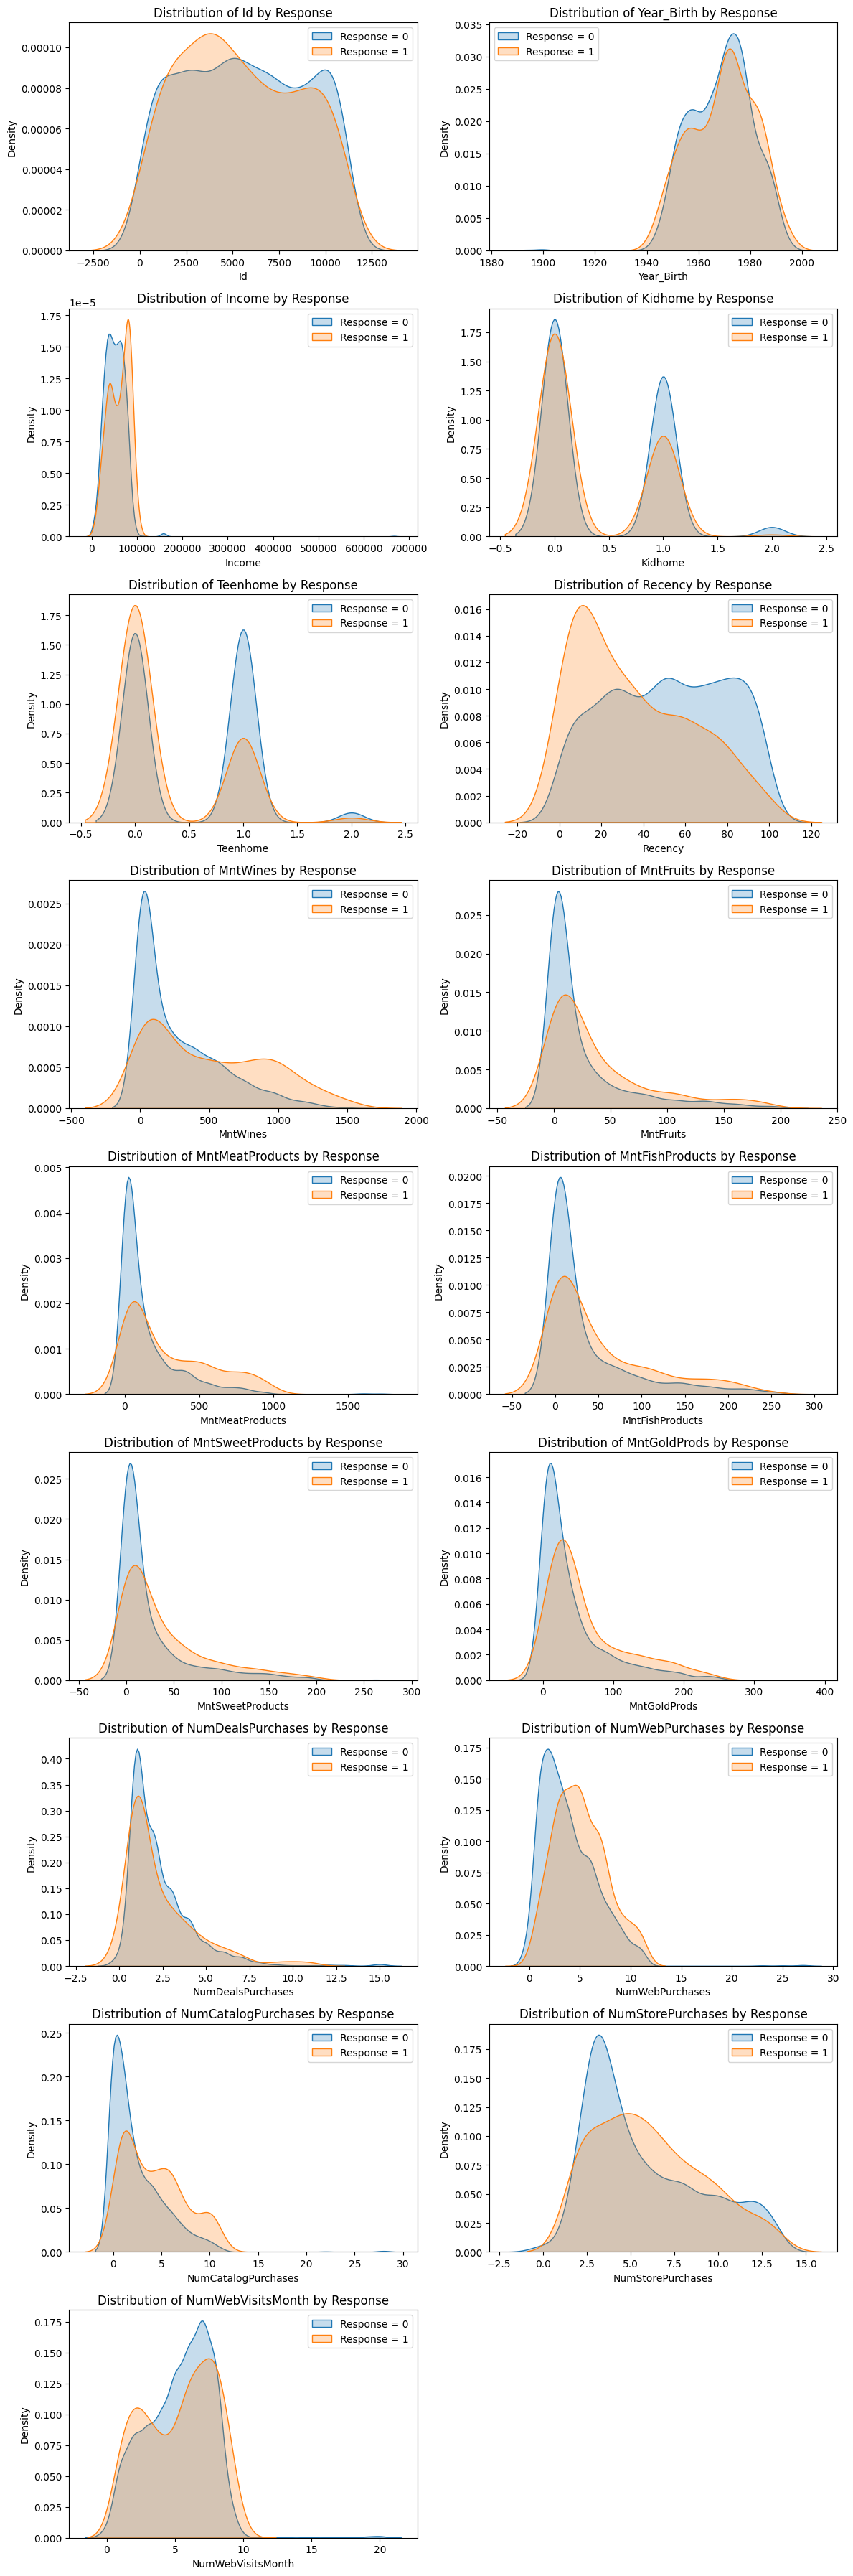

In [48]:
num_plots = len(numeric_cols)          # Total number of numeric columns
rows = math.ceil(num_plots / 2)        # Number of rows needed
fig, axes = plt.subplots(rows, 2, figsize=(12, 4*rows))  # Create a grid of subplots
axes = axes.flatten()                 

for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=data[data['Response'] == 0][col], label="Response = 0", fill=True, ax=axes[i])
    sns.kdeplot(data=data[data['Response'] == 1][col], label="Response = 1", fill=True, ax=axes[i])

    axes[i].set_title(f'Distribution of {col} by Response')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")
    axes[i].legend()

# If there's an odd number of columns, turn off the unused subplot(s)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()